In [96]:
## Full Pipeline Script
# Step 1: Setup and Import Libraries
import mne
import numpy as np
import pandas
# import torch
# import torch.nn as nn
# import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from mne.decoding import CSP
from mne.preprocessing import ICA
import pyxdf

import matplotlib.pyplot as plt

[Pipeline of old paper]<img src="pipeline.png" width="800" height="400">

# Functions and definitions

In [97]:
def get_cue_duration(cue_name: str) -> float:
    """TODO: Improve, hardcoded"""
    cue_options = ["pre_cue", "hand", "foot", "pause"]
    
    if cue_name == "pre_cue":
        cue_duration = 2.0
    elif cue_name in ["hand", "foot"]:
        cue_duration = 4.5
    elif cue_name == "pause":
        cue_duration = 2.5
    else:
        raise ValueError(f"Unknown cue name '{cue_name}', choose from: {', '.join(cue_options)}")

    return cue_duration
    

# Processing pipeline

In [98]:
# Load XDF data
file_name = "../Mirage91/Pilot/block_.xdf"
streams, header = pyxdf.load_xdf(file_name)
# streams[1] EEG, streams[2] cues/marker

### Load Data and prepare for further processing with MNE

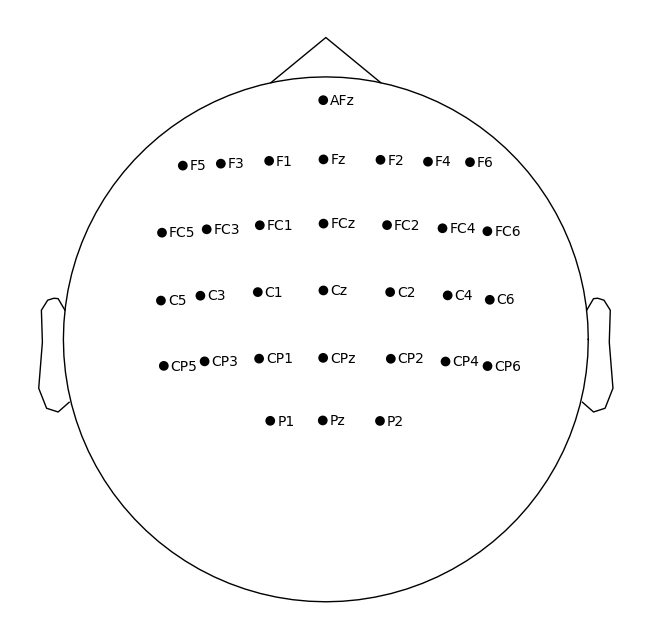

LOF: Detected bad channel(s): ['F5', 'F2', 'C2', 'CP3', 'P2']
['F5', 'F2', 'C2', 'CP3', 'P2']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 90.0 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 5 sensors
[]
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 32 x 820674 (1641.3 s), ~200.4 MB, data loaded>

In [99]:
time_buffer = 10  # at the end
eeg_streams = [current_stream for current_stream in streams if current_stream['info']["name"][0] == 'BrainVision RDA']

if len(eeg_streams) == 1:
    eeg_stream = eeg_streams[0]

else:
    raise ValueError()

stim_streams = [current_stream for current_stream in streams if current_stream['info']["name"][0] == 'paradigm']

if len(stim_streams) == 1:
    stim_stream = stim_streams[0]

else:
    raise ValueError()

eeg_info = eeg_stream["info"]

eeg_onset = float(eeg_info["created_at"][0])
cue_onset = float(stim_stream["info"]["created_at"][0])

eeg_first_timestep = float(eeg_stream["footer"]["info"]["first_timestamp"][0])
cue_first_timestep = float(stim_stream["footer"]["info"]["first_timestamp"][0])

if eeg_first_timestep < cue_first_timestep:
    start_of_trial = eeg_first_timestep
else:
    start_of_trial = cue_first_timestep

# f_s = float(eeg_info["nominal_srate"][0])
f_s = float(eeg_info["effective_srate"])

eeg_time_stamps = eeg_stream['time_stamps']
cue_time_stamps = stim_stream['time_stamps']

eeg_time_stamps = eeg_time_stamps - start_of_trial
cue_time_stamps = cue_time_stamps - start_of_trial

last_cue_time_stamp = cue_time_stamps[-1]
end_of_trial_time = last_cue_time_stamp + time_buffer
end_of_trial = np.ceil(end_of_trial_time * f_s).astype(int)

eeg_data = eeg_stream['time_series']
eeg_data = eeg_data.T
eeg_data = eeg_data[:, :end_of_trial]

cue_names = stim_stream['time_series']
cue_names = [element[0] for element in cue_names]
cue_durations = [get_cue_duration(current_cue_name) for current_cue_name in cue_names]
num_channels, num_time_steps = eeg_data.shape

channel_names = [element["label"][0] for element in eeg_info["desc"][0]["channels"][0]["channel"]]

raw = mne.io.RawArray(eeg_data*10e-6, mne.create_info(
    ch_names=channel_names,
    sfreq=f_s,
    ch_types='eeg'), verbose=False)

raw.drop_channels(['x_dir', 'y_dir', 'z_dir'])
raw_copy = raw.copy()
##raw.add_reference_channels("FCz")
raw.set_montage("standard_1020")
raw.plot_sensors(show_names=True)

## Mark and interpolate bad channels
bad_ch = mne.preprocessing.find_bad_channels_lof(raw)
# for i in bad_ch:
#     raw.info["bads"].append(i)
raw.info["bads"].extend(bad_ch)
print(raw.info["bads"])
raw.interpolate_bads()
print(raw.info["bads"])
## REREFERENCE - CAR
raw.set_eeg_reference("average",projection=False)

annotations = mne.Annotations(onset=cue_time_stamps,
                              duration=cue_durations,
                              description=cue_names,)
raw.set_annotations(annotations)

### Filtering

In [100]:
# Apply filters

# FIR

raw.filter(0.8, None, fir_design='firwin', verbose=False)  # Highpass filter at 1 Hz
raw.notch_filter(50., fir_design='firwin', verbose=False)  # Notch filter at 50 Hz
raw.filter(None, 80., fir_design='firwin', verbose=False)  # Anti-aliasing filter at 80 Hz

# IIR

# raw.filter(1., None, method='iir', )  # verbose=False)  # Highpass filter at 1 Hz
# raw.notch_filter(50., method='iir')  # verbose=False)  # Notch filter at 50 Hz
# raw.filter(None, 80., method='iir')  # , verbose=False)  # Anti-aliasing filter at 80 Hz

# Downsample to 250 Hz
raw.resample(250)


#extract events and especially 1 - foot and 2 - hand
all_events, all_event_id = mne.events_from_annotations(raw)
all_events = all_events[np.in1d(all_events[:, 2], (1,2)), :]

Used Annotations descriptions: ['foot', 'hand', 'pause', 'pre_cue']


In [101]:
data = raw.get_data()
print("MIN clean: ", np.min(data))
print("MEAN clean: ", np.mean(data))
print("MAX clean: ", np.max(data))
data_copy = raw_copy.get_data()
print("MIN: ", np.min(data_copy))
print("MEAN: ", np.mean(data_copy))
print("MAX: ", np.max(data_copy))

MIN clean:  -0.007070181493376949
MEAN clean:  -3.271765468729485e-22
MAX clean:  0.005787987019371819
MIN:  -0.15378987789154053
MEAN:  -0.038033836173483604
MAX:  0.09972289949655533


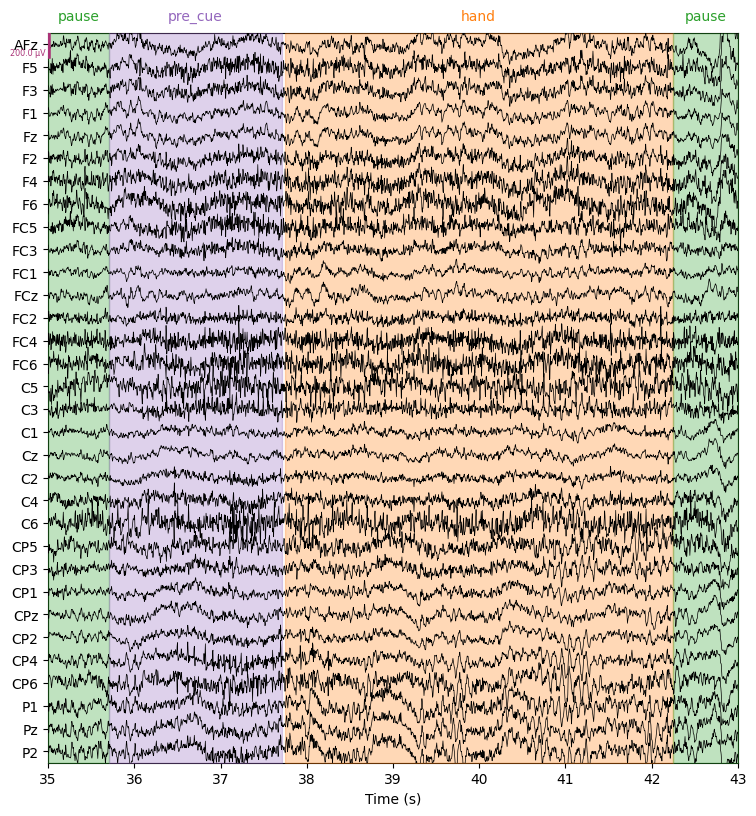

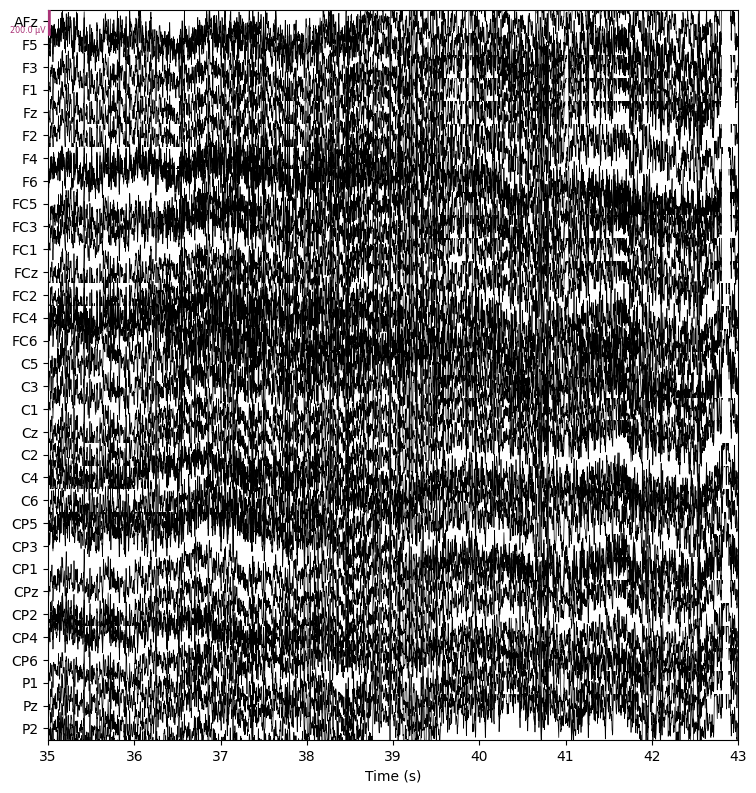

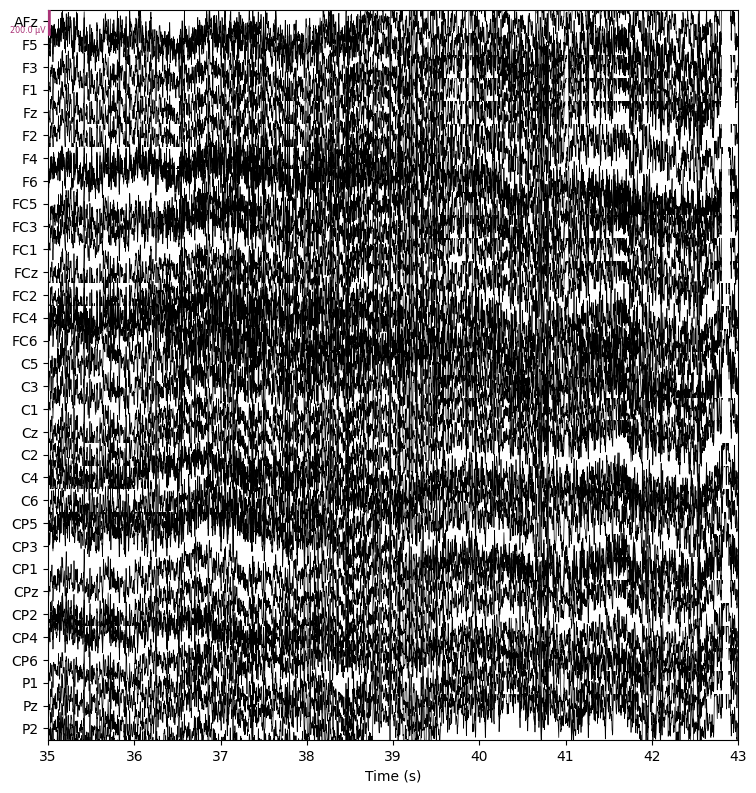

In [102]:
## Compare RAW and CLEANED DATA and rename again in epochs
scale=dict(eeg=100e-6, eog=150e-6)
raw.plot(n_channels=32,scalings=scale,start=35, duration=8, show_scrollbars=False)
raw_copy.plot(n_channels=32,scalings=scale,start=35, duration=8, show_scrollbars=False)

### Epoching in PRE CUE + CUE

Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['F4', 'FC4', 'FC6', 'C2', 'C4', 'C6']
2 bad epochs dropped
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated


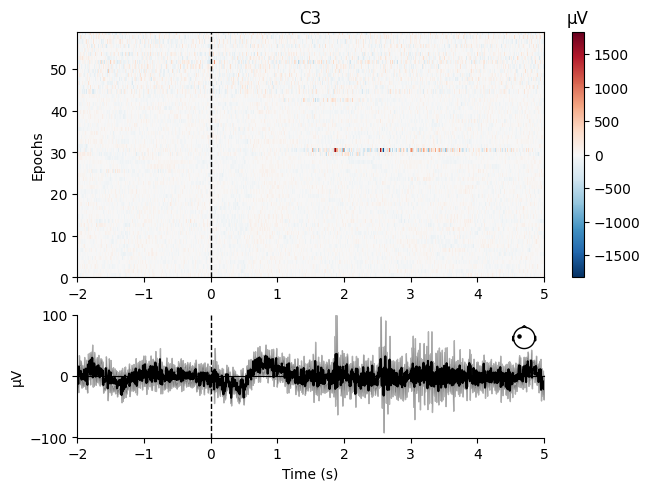

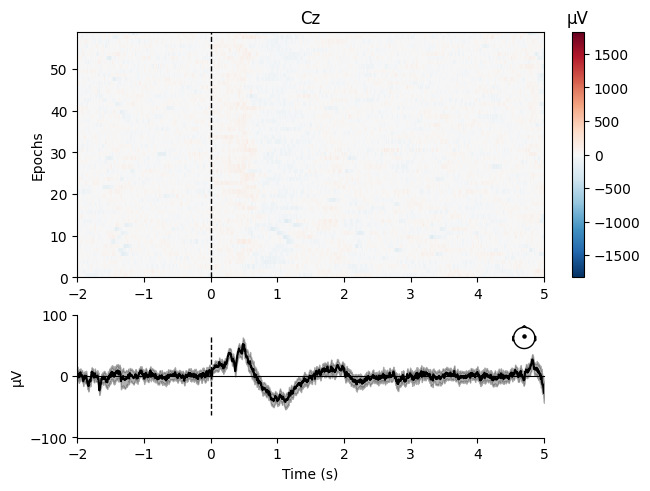

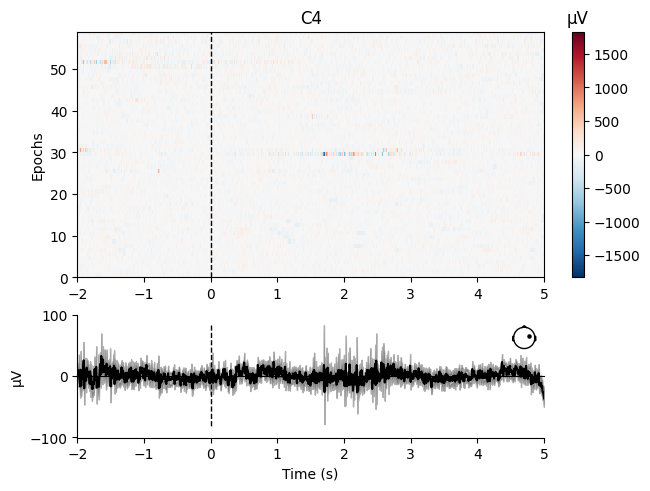

Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated


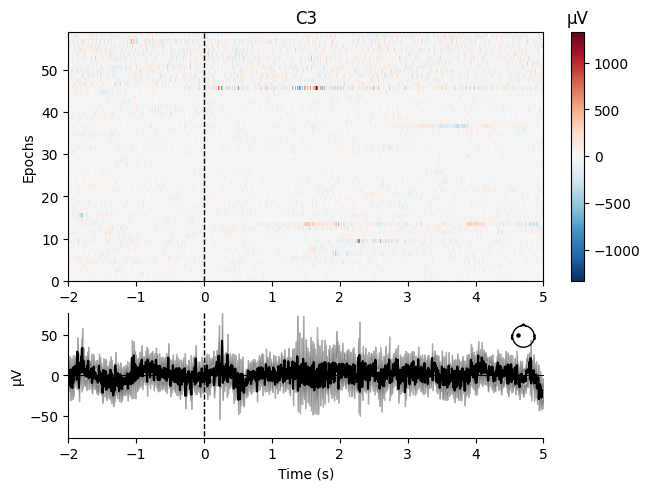

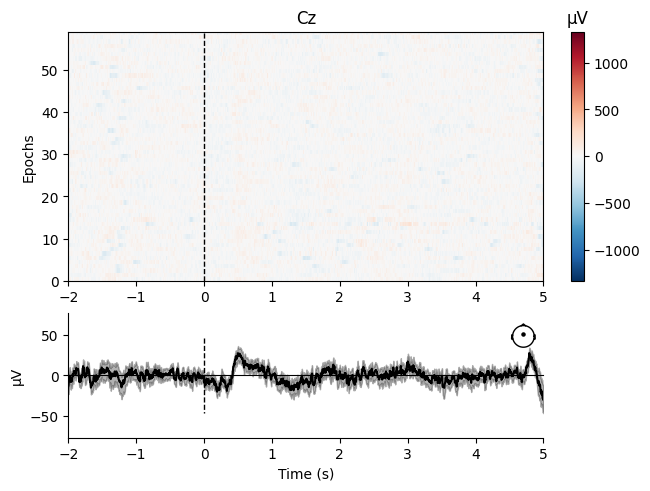

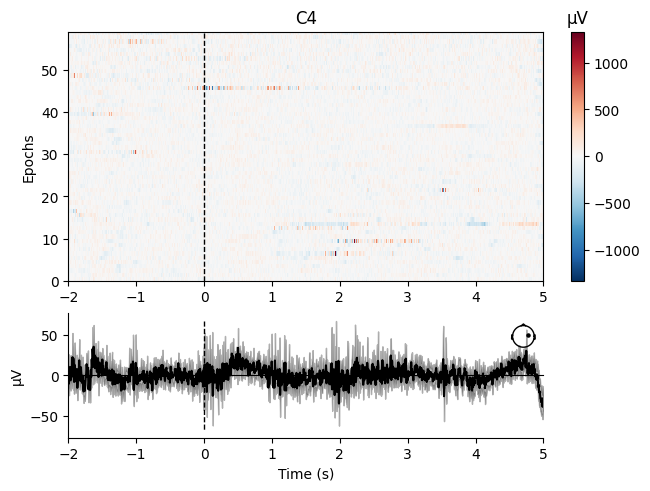

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [103]:
## EPOCHING: pre cue 2s and cue 4.5s
reject_criteria = dict(
    mag=3000e-15,  # 3000 fT
    grad=3000e-13,  # 3000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=200e-6,
)  # 200 µV

tmin, tmax = -2, 5
epochs = mne.Epochs(
    raw,
    all_events,
    dict(foot=all_event_id["foot"], hand=all_event_id["hand"]),
    tmin,
    tmax,
    detrend=1,
    #picks=("C3","C1","Cz","C2","C4"),
    baseline=(-2.,0),
    preload=True
)
reject_criteria = dict(eeg=5000e-6)  # 100 µV
epochs.drop_bad(reject=reject_criteria)
# hand_epochs = epochs["hand"]
# foot_epochs = epochs["foot"]
epochs['foot'].plot_image(picks=["C3", "Cz", "C4"])
epochs['hand'].plot_image(picks=["C3", "Cz", "C4"])

### Start Artifact Detection & Rejection

In [104]:
def run_ica(raw_data, method, fit_params=None):
    ica = ICA(
        n_components=20,
        method=method,
        fit_params=fit_params,
        max_iter="auto",
        random_state=0,
    )
    
    ica.fit(raw_data)
    title = f"ICA decomposition using {method}"
    ica.plot_components(title=title)
    ica.plot_sources(raw_data, start=35, stop=35+6,show_scrollbars=True)
    ica.plot_properties(raw_data, picks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    
    ica.exclude = [0,1]#,10, 4,6,9,12, 2]
    return ica.apply(raw_data)

Fitting ICA to data using 32 channels (please be patient, this may take a while)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\194711041.py:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(raw_data)


Selecting by number: 20 components
Computing Infomax ICA
Fitting ICA took 90.0s.


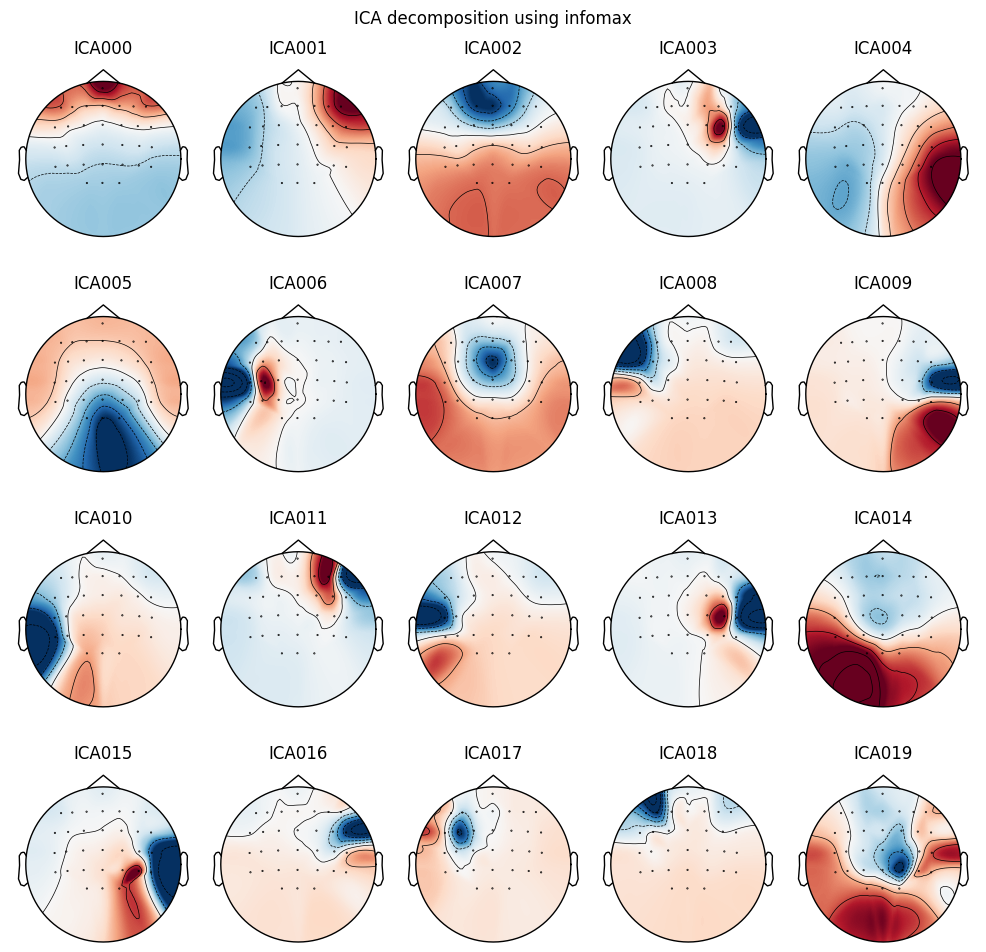

Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated


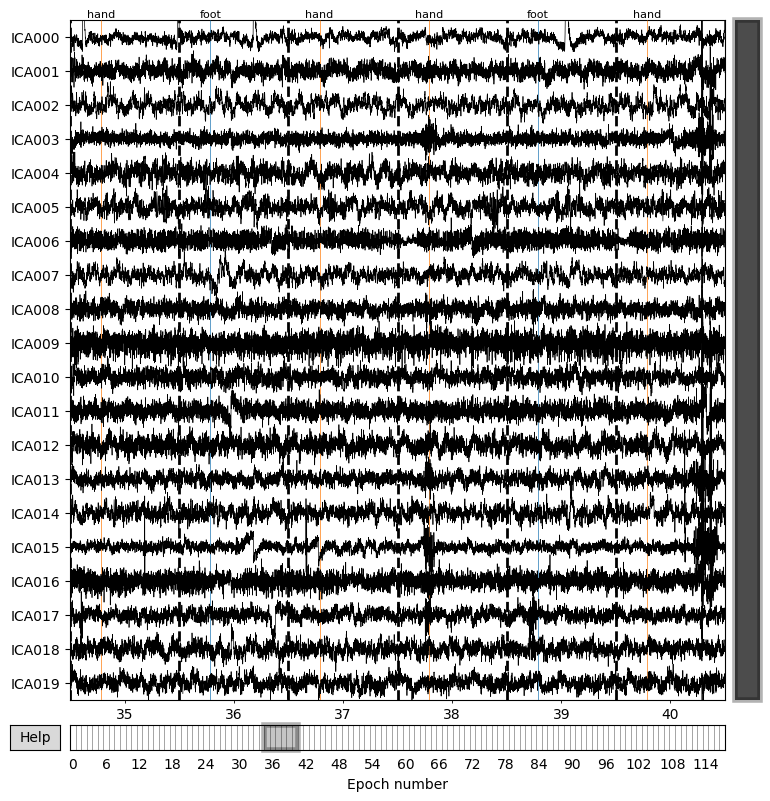

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
118 matching events found
No baseline correction applied
0 pro

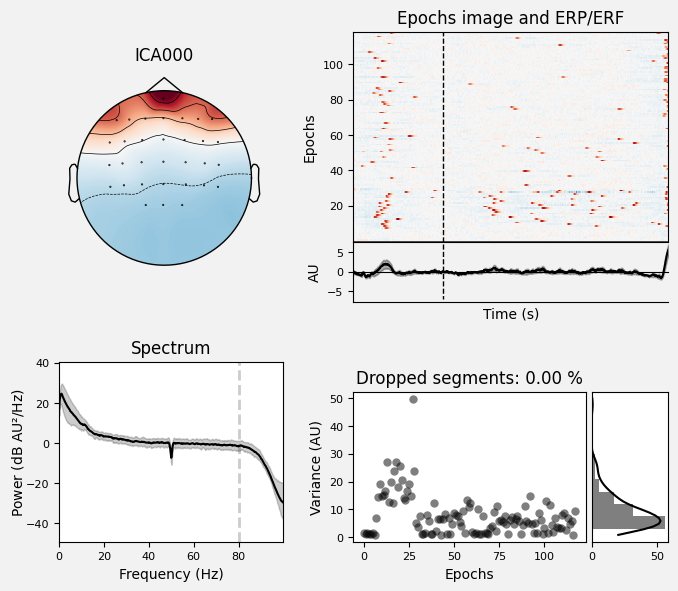

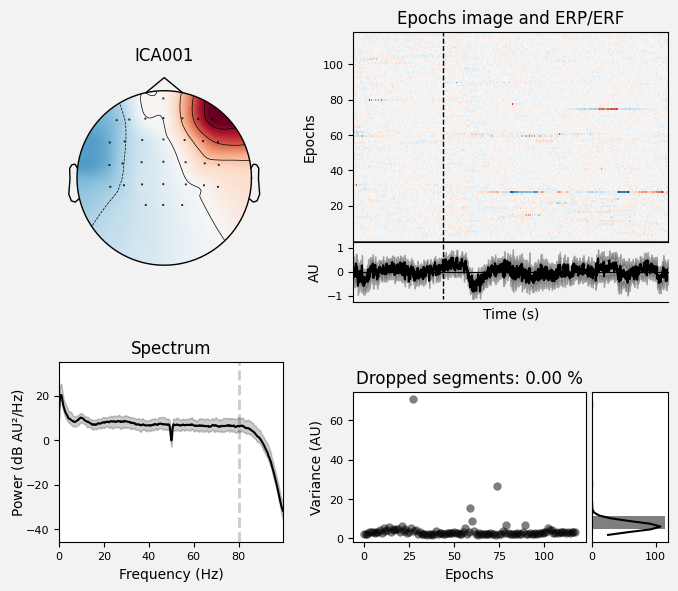

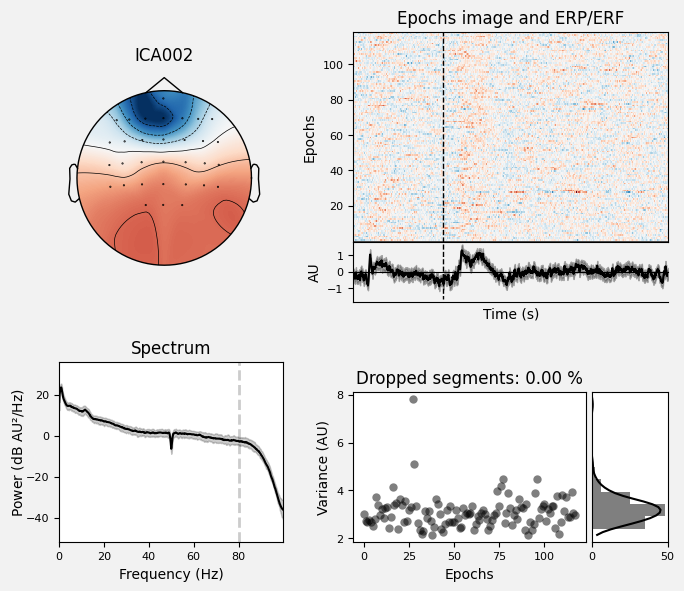

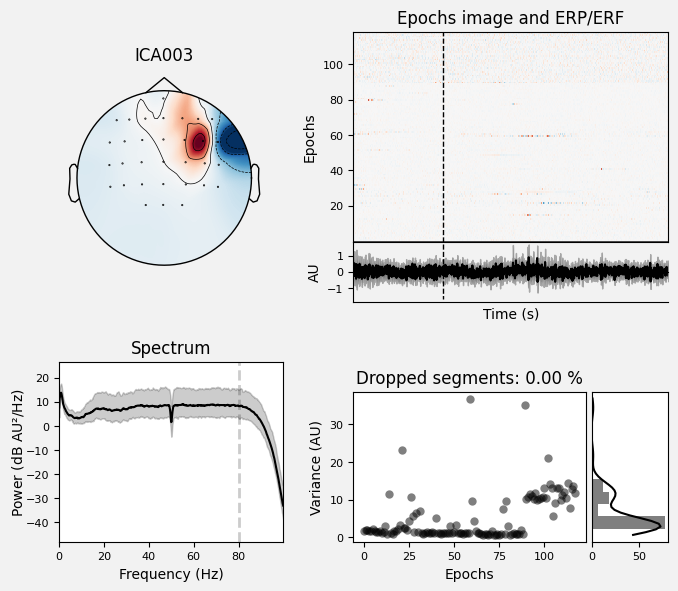

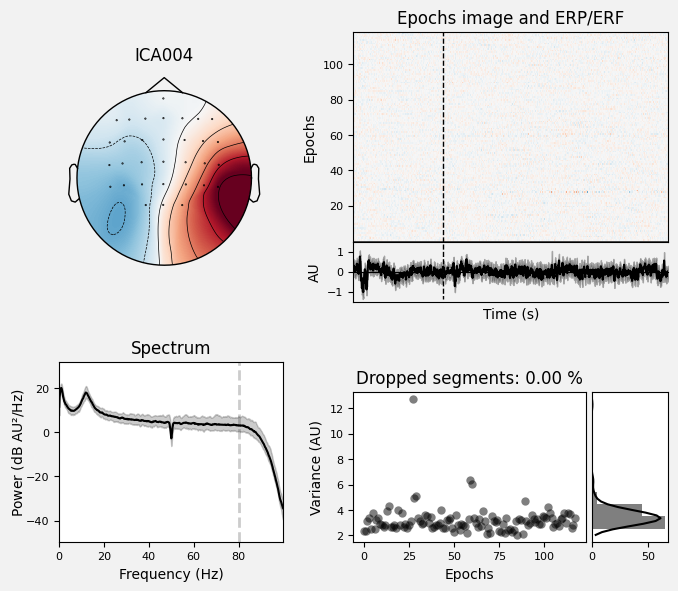

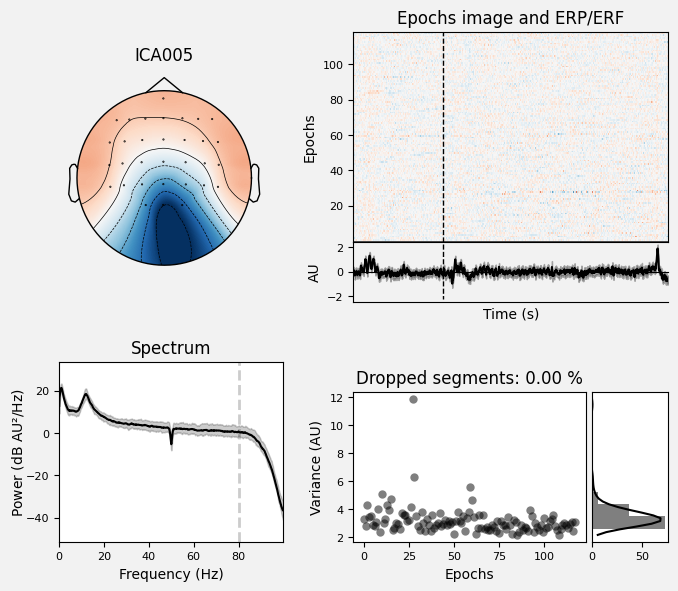

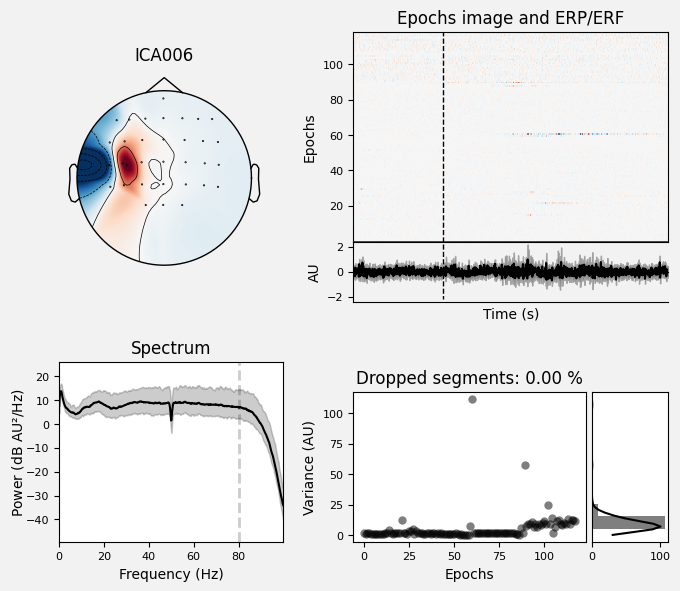

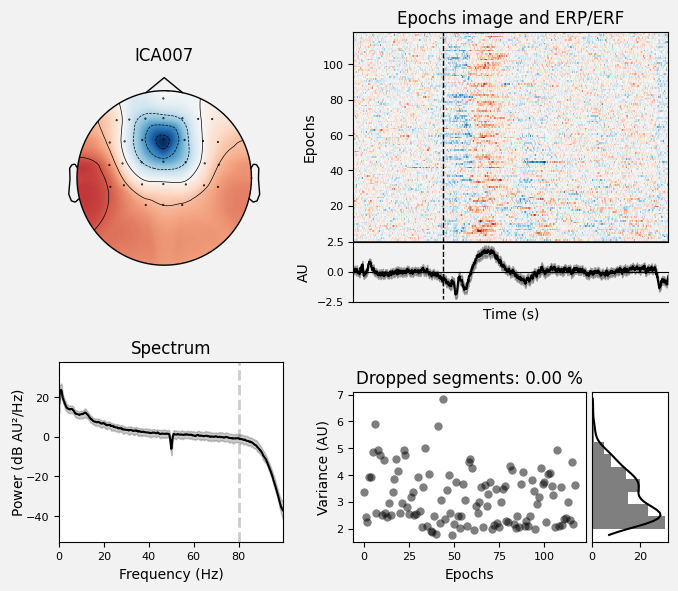

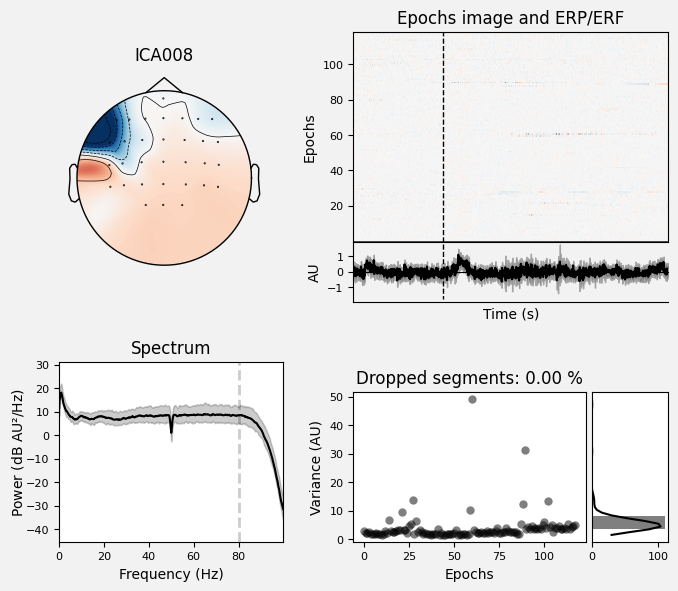

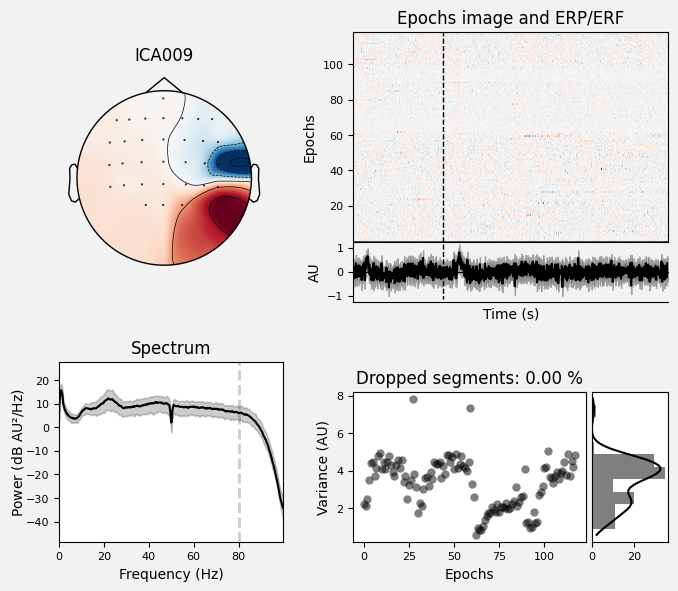

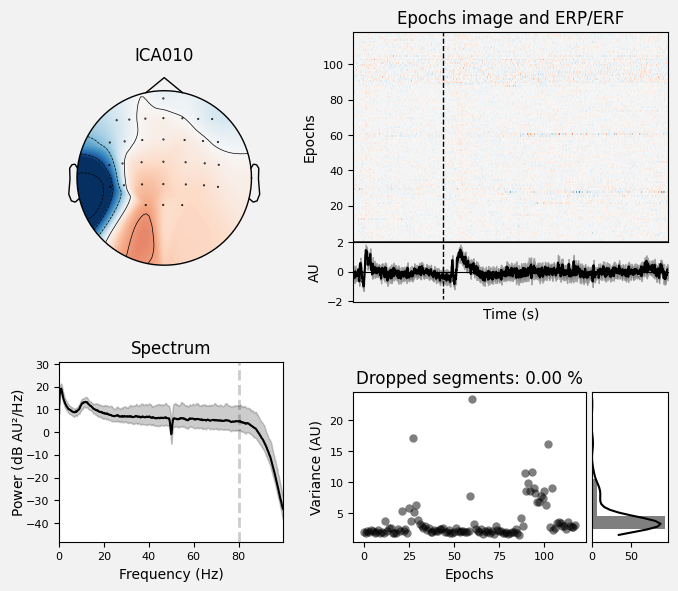

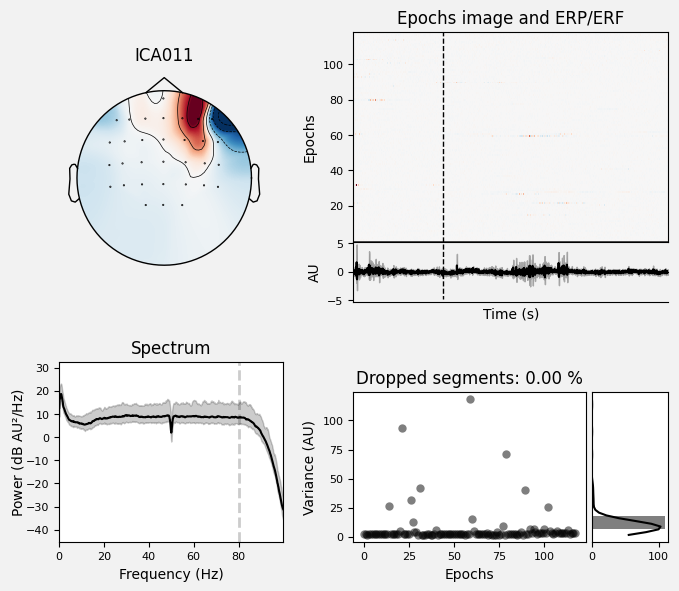

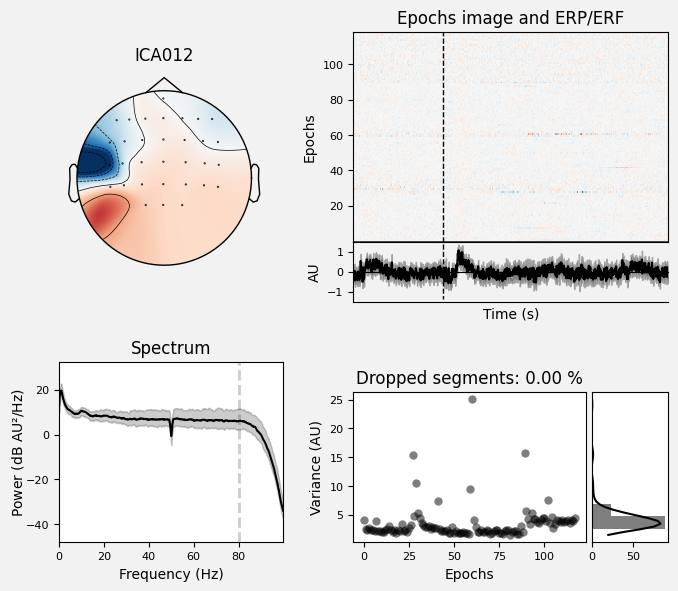

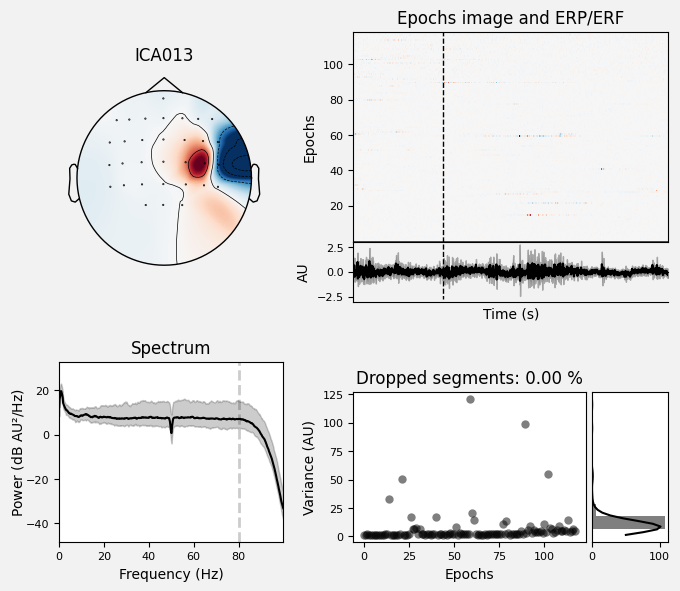

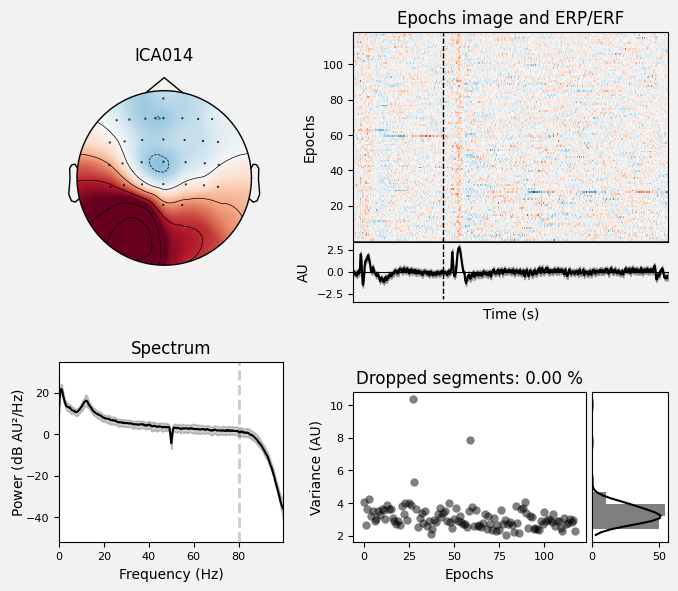

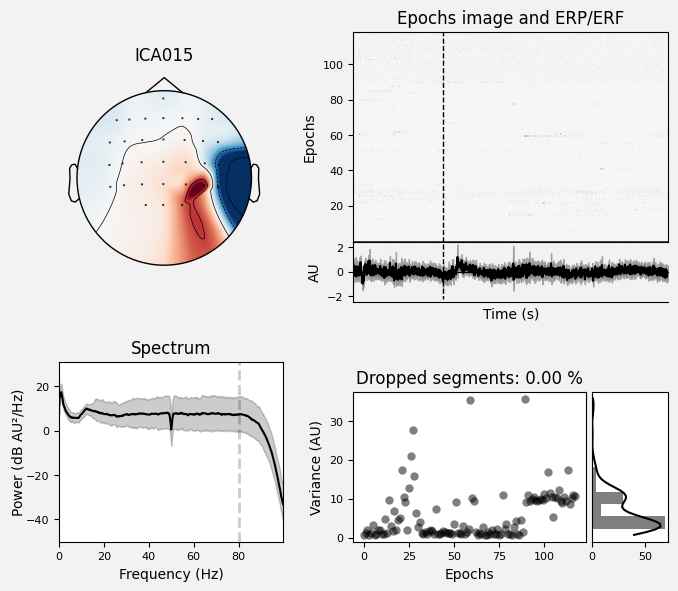

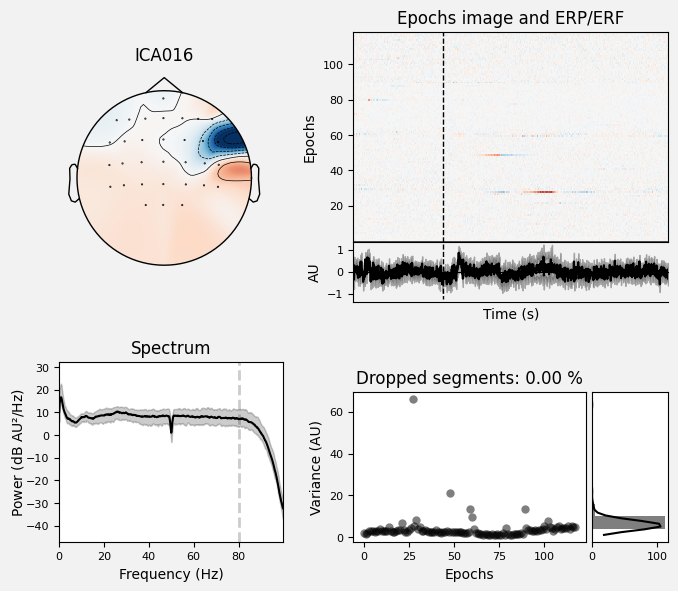

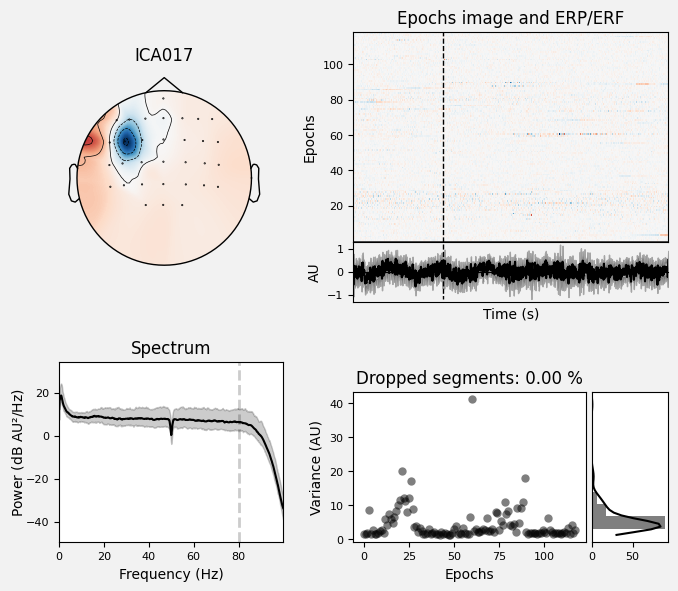

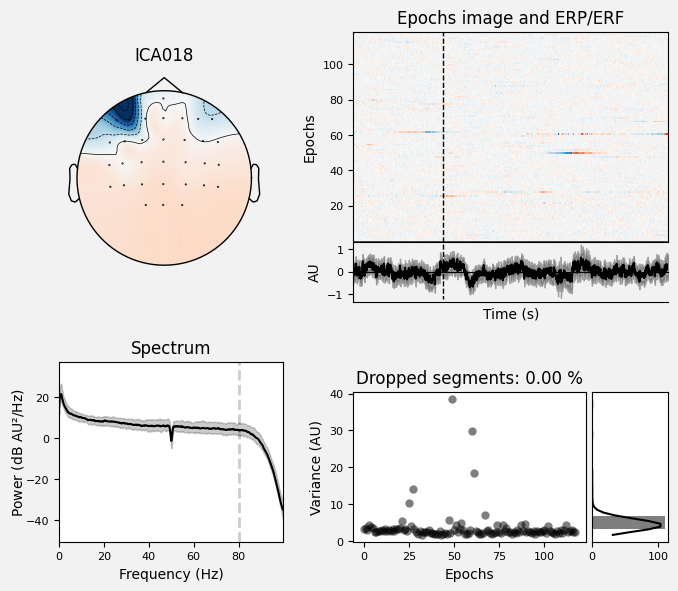

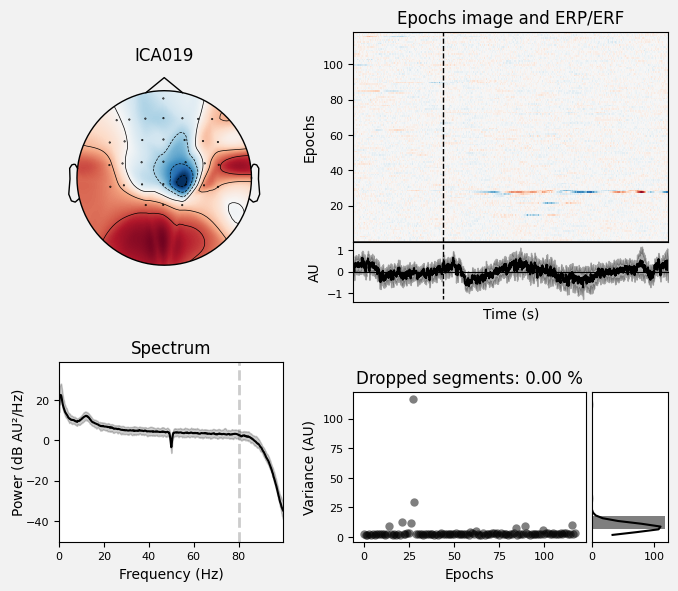

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\194711041.py:17: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  return ica.apply(raw_data)


In [105]:
## different methods for ICA
raw_epochs = run_ica(epochs,"infomax")
#raw_clean = run_ica(epochs,"infomax", fit_params=dict(extended=True))
#raw_clean = run_ica(epochs,"fastica")

In [ ]:
## Compare RAW and CLEANED DATA and rename again in epochs
raw.plot(n_channels=32,scalings="auto",start=35, duration=8, show_scrollbars=False)
raw_epochs.plot(n_channels=32, show_scrollbars=False)
epochs = raw_epochs


### START Spatial Filtering

In [ ]:
## CSP FILTERING -MISSING
bands = np.array([6,11,8,13, 15,26, 25,36])

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit_transform(epochs.get_data(), epochs.events[:, -1])

### PLOT ERDS Maps

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    5.8s


Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\1109520443.py:16: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)


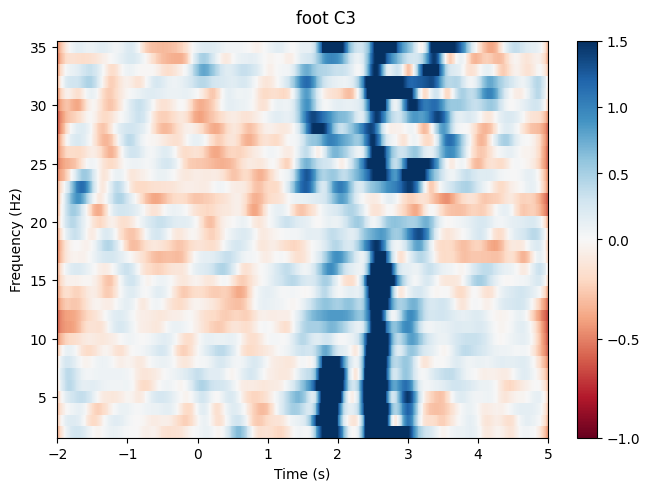

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\1109520443.py:16: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)


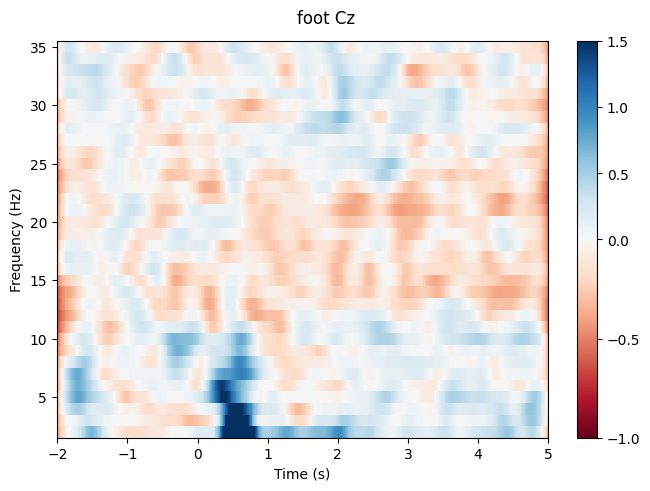

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\1109520443.py:16: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)


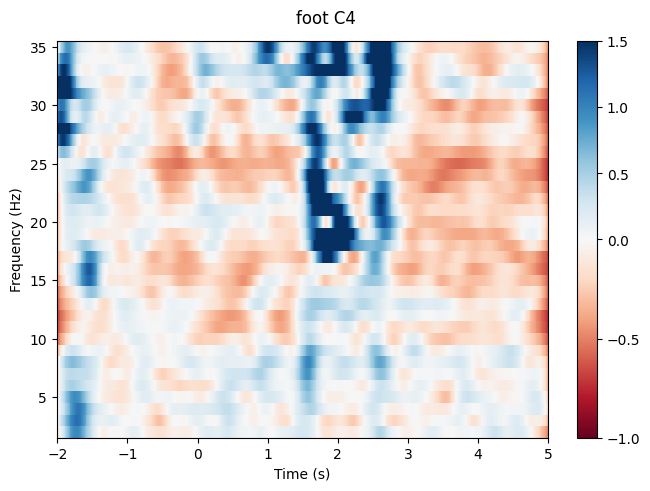

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    5.9s


Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\1109520443.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


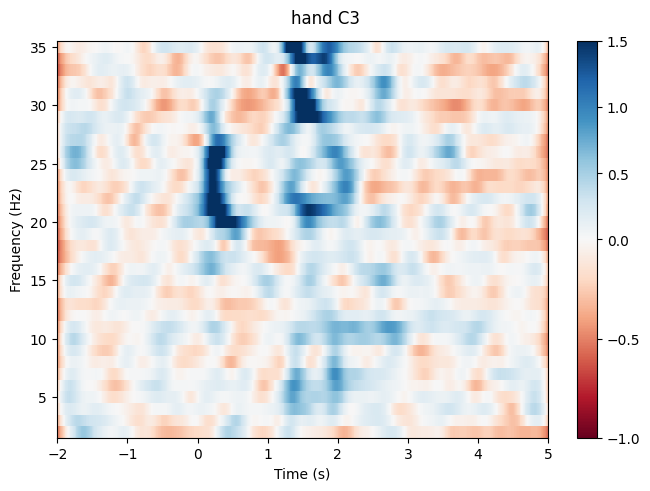

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\1109520443.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


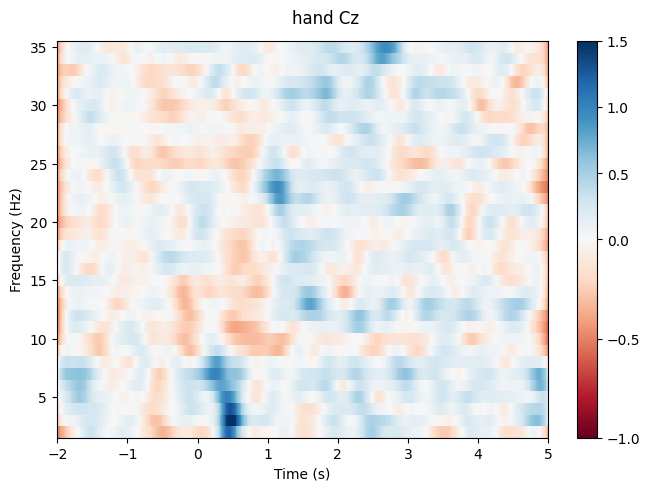

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_39016\1109520443.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


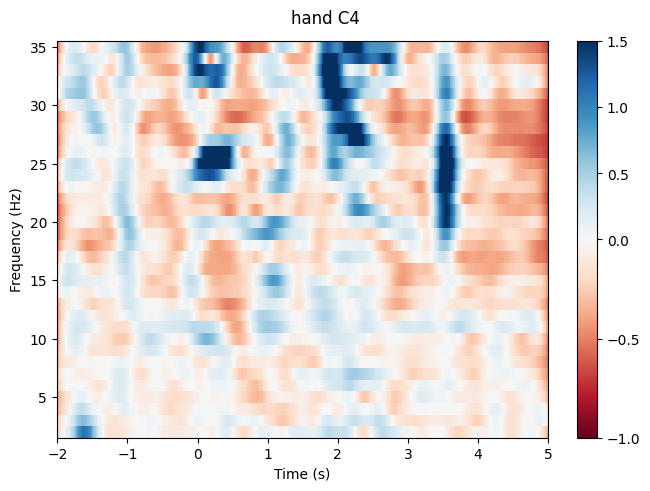

In [106]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper

freqs = np.arange(2, 36)
baseline = -1.5, -0.5
vmin, vmax = -1, 1.5
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

## ERDS maps foot C3,Cz,C4
chan_of_interest = ["C3","Cz","C4"]
erds_foot = epochs['foot'].compute_tfr('morlet', n_cycles=freqs, return_itc=False, freqs=freqs, decim=3, average=True)
#erds_foot.crop(-1.5,4.5).apply_baseline(baseline,mode="percent")
#erds_foot.plot(["C3","Cz","C4"])
for i in chan_of_interest:
    erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)

# ## ERDS map hand C3,Cz,C4
erds_hand = epochs['hand'].compute_tfr('morlet', n_cycles=freqs, return_itc=False, freqs=freqs, decim=3, average=True)
for i in chan_of_interest:
    erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


In [ ]:
# ## OR in one plot together:
# chan_interest =  ["C4","C2","Cz","C1","C3"]
# epochs_interest = epochs.copy().pick_channels(chan_interest)
# for event in epochs.event_id:  # for each condition
#     fig, axes = plt.subplots(1, 5, figsize=(15, 5))
#     tfr, itc = tfr_multitaper(epochs_interest[event], freqs=freqs, n_cycles=freqs)
#     tfr.crop(-1.5, 4.5).apply_baseline(baseline, mode="percent")
#     itc.crop(-1.5, 4.5)
#     tfr.plot(
#         vmin=vmin,
#         vmax=vmax,
#         title=event,
#         axes=axes,
#         cmap="RdBu",
#         cnorm=cnorm,
#         show=False
#     )
#     for i, ax in enumerate(axes):
#         ax.set_title(epochs_interest.info["ch_names"][i])
# plt.show()

In [ ]:
## SHOWS TIME AND SPATIAL DEPENDENCY OF SIGNAL
# ## TOPOPLOT USING AGAIN ALL CHANNELS
# ## maybe good to improve classification among different classes if time is changing
# epochs = mne.Epochs(
#     raw_clean,
#     all_events,
#     dict(foot=all_event_id["foot"], hand=all_event_id["hand"]),
#     tmin,
#     tmax,
#     baseline=None,
#     preload=True
# )
# # otherwise add above: picks=("C3","C1","Cz","C2","C4") 
# epochs["foot"].average().plot_topomap(times=[-0.5, 0.0, 0.5, 1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5], ch_type="eeg")
# epochs["hand"].average().plot_topomap(times=[-0.5, 0.0, 0.5, 1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5], ch_type="eeg")

### Start Training and Classification

In [107]:
## START Training
X = epochs.get_data(copy=False)
y = epochs.events[:, 2]
print(np.shape(X), np.shape(y))

(118, 32, 1751) (118,)


In [110]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA,SparsePCA
from mne.decoding import (
    CSP,
    FilterEstimator,
    UnsupervisedSpatialFilter,
    cross_val_multiscore
)
## bandpass filter (between 8–30 Hz), PCA (which retains the 30 largest components), CSP, and LDA.
clf = make_pipeline(
    FilterEstimator(epochs.info, 5, 35),
    UnsupervisedSpatialFilter(PCA(5)),
    CSP(),
    LinearDiscriminantAnalysis()
)
## train and evaluate this pipeline in a 5-fold cross-validation
scores = cross_val_multiscore(clf, X, y,cv=10, verbose=True)
print("result cross-validation: ",scores, "and mean:")
scores.mean()

Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 5 dim * 4.2e+10  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-05 (2.2e-16 eps * 5 dim * 4.2e+10  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-05 (2.2e-16 eps * 5 dim * 4.2e+10  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=1 covariance using EMPIRICAL
Done.
Estim

0.46590909090909094

### Ideas

In [ ]:
bands = {
    "6-10": (6, 10),
    "8-12": (8, 12),
    "15-25": (15, 25),
    "25-35": (25, 35)
}

# Step 6: Extract Bandpower Features
def compute_bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    psd, freqs = mne.time_frequency.psd_array_welch(data, sf, fmin=low, fmax=high, verbose=0)
    psd = psd.mean(axis=0)

    bp = np.trapz(psd, freqs)

    if relative:
        bp /= np.trapz(psd, freqs)

    return bp

sfreq = raw.info['sfreq']
X = []
for band in bands.values():
    X.append(compute_bandpower(epochs.get_data(), sfreq, band))

X = np.stack(X, axis=-1)
y = epochs.events[:, -1]

## bandpass filter (between 8–30 Hz), PCA (which retains the 30 largest components), CSP, and logistic regression.
clf = make_pipeline(
    FilterEstimator(epochs.info, 8, 30),
    UnsupervisedSpatialFilter(PCA(32)),
    CSP(),
    LogisticRegression()
)

## train and evaluate this pipeline in a 5-fold cross-validation
scores = cross_val_multiscore(clf, X, y, cv=5, verbose=True)
print("result cross-validation: ",scores, "and mean:")
scores.mean()

In [ ]:
clf

# Tests

In [ ]:
fig = raw.plot(start=35, duration=10, scalings="auto")
## Do we have PROBLEMS WITH SCALING? 